In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [43]:
events = pd.read_csv("events.csv")
category_tree = pd.read_csv("category_tree.csv")
item_properties_1= pd.read_csv("item_properties_part1.csv")
item_properties_2= pd.read_csv("item_properties_part2.csv")
item_properties = pd.concat([item_properties_1, item_properties_2], ignore_index=True)
del item_properties_1, item_properties_2

In [44]:
events.head()

timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

In [45]:
item_properties.head()

timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513

In [46]:
category_tree.head()

categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0

In [47]:
print("Number of users: ",events["visitorid"].nunique())
print("Number of items: ",item_properties["itemid"].nunique())
print("Number of item properties: ",item_properties["property"].nunique())

Number of users:  1407580
Number of items:  417053
Number of item properties:  1104


In [48]:
#We cannot use transaction id, so we will drop it
events = events.drop(['transactionid'],axis=1)

In [49]:
events=events.drop_duplicates()
item_properties = item_properties.drop_duplicates()

In [50]:
events['timestamp']= pd.to_datetime(events['timestamp'],unit='ms')
print("start_time:",events['timestamp'].min())
print("End time", events['timestamp'].max())

start_time: 2015-05-03 03:00:04.384000
End time 2015-09-18 02:59:47.788000


In [51]:
# We need to split the data into train and validation. We have a 
cutoff_time = pd.to_datetime('2015-09-01')
events_train = events[events['timestamp']<=cutoff_time]
events_valid = events[events['timestamp']>cutoff_time]
print("Training data distribution")
print(events_train['event'].value_counts())
print("Valid data distribution")
print(events_valid['event'].value_counts())
del events

Training data distribution
event
view           2370571
addtocart        61324
transaction      20088
Name: count, dtype: int64
Valid data distribution
event
view           293647
addtocart        7642
transaction      2369
Name: count, dtype: int64


In [72]:
def process_popularity(df, level):

    if level=="itemid":
        col= "visitorid"
    elif level=="visitorid":
        col="itemid"
    # Count occurrences of each event type
    event_counts = df.groupby([level, "event"])[col].count().unstack(fill_value=0)
    event_counts.columns = ["number_of_addtocart", "number_of_purchases","number_of_views"]

   
    event_counts = event_counts.reset_index()

    event_counts["addtocart_to_view_ratio"] = (
    event_counts["number_of_addtocart"] / event_counts["number_of_views"]
    ).where(event_counts["number_of_views"] > 0, 0)

    event_counts["purchase_to_view_ratio"] = (
        event_counts["number_of_purchases"] / event_counts["number_of_views"]
    ).where(event_counts["number_of_views"] > 0, 0)

    event_counts["purchase_to_addtocart_ratio"] = (
        event_counts["number_of_purchases"] / event_counts["number_of_addtocart"]
    ).where(event_counts["number_of_addtocart"] > 0, 0)

    # Compute unique visitors and visits
    visitor_counts = df.groupby(level)[col].nunique().reset_index()
    visitor_counts.columns = [level, f"number_of_unique_{col[:-2]}s"]

    # visit_counts = df.groupby([level, "timestamp"]).size().groupby(level).size().reset_index()
    # visit_counts.columns = [level, "number_of_visits"]

    # result = event_counts.merge(visitor_counts, on=level).merge(visit_counts, on=level)
    result = event_counts.merge(visitor_counts, on=level)

    return result

popularity_item = process_popularity(events_train, level = "itemid")
popularity_user = process_popularity(events_train, level = "visitorid")

In [82]:
popularity_item

itemid  number_of_addtocart  number_of_purchases  number_of_views  \
0            3                    0                    0                2   
1            4                    0                    0                2   
2            6                    0                    0               29   
3            9                    0                    0                2   
4           15                    3                    1               18   
...        ...                  ...                  ...              ...   
222977  466861                    5                    1               82   
222978  466862                    0                    0                3   
222979  466863                    0                    0                1   
222980  466864                    2                    0               87   
222981  466867                    0                    0                4   

        addtocart_to_view_ratio  purchase_to_view_ratio  \
0                      0.000000                0.000000   
1                      0.000000                0.000000   
2                      0.000000                0.000000   
3                      0.000000                0.000000   
4                      0.166667                0.055556   
...                         ...                     ...   
222977                 0.060976                0.012195   
222978                 0.000000                0.000000   
222979                 0.000000                0.000000   
222980                 0.022989                0.000000   
222981                 0.000000                0.000000   

        purchase_to_addtocart_ratio  number_of_unique_visitors  \
0                          0.000000                          2   
1                          0.000000                          2   
2                          0.000000                         26   
3                          0.000000                          2   
4                          0.333333                         13   
...                             ...                        ...   
222977                     0.200000                         69   
222978                     0.000000                          3   
222979                     0.000000                          1   
222980                     0.000000                         56   
222981                     0.000000                          4   

        number_of_visits  
0                      2  
1                      2  
2                     29  
3                      2  
4                     22  
...                  ...  
222977                88  
222978                 3  
222979                 1  
222980                89  
222981                 4  

[222982 rows x 9 columns]

In [75]:
popularity_item.to_csv("popularity_item.csv", index=False)
popularity_user.to_csv("popularity_user.csv", index=False)

In [12]:
print("items in training data: ", events_train['itemid'].nunique())

items in training data:  222982


In [13]:
category_tree=category_tree.dropna()
category_tree['categoryid'] = category_tree['categoryid'].astype(int)
category_tree['parentid'] = category_tree['parentid'].astype(int)
category_tree_df = pd.DataFrame(item_properties[item_properties['property']=='categoryid']['value'])
category_tree_df = category_tree_df.drop_duplicates()

In [14]:
category_tree_df.rename(columns={'value':'categoryid'},inplace=True)
category_tree_df['categoryid'] = category_tree_df['categoryid'].astype(int)
category_tree_df = merge_with_category_paths(category_tree_df, category_tree)

In [15]:
category_tree_df

categoryid  parent_level_1  parent_level_2  parent_level_3  \
0               1338          1278.0           395.0             NaN   
140             1277           312.0           653.0             NaN   
151             1059          1696.0           378.0             NaN   
189             1147          1027.0           250.0             NaN   
197               47           381.0          1482.0             NaN   
...              ...             ...             ...             ...   
19303137        1156          1200.0           395.0             NaN   
19333963         794           602.0           791.0             NaN   
19381266         143          1482.0             NaN             NaN   
19490058        1548          1499.0           351.0           653.0   
19771512         391           250.0             NaN             NaN   

          parent_level_4  parent_level_5  
0                    NaN             NaN  
140                  NaN             NaN  
151                  NaN             NaN  
189                  NaN             NaN  
197                  NaN             NaN  
...                  ...             ...  
19303137             NaN             NaN  
19333963             NaN             NaN  
19381266             NaN             NaN  
19490058             NaN             NaN  
19771512             NaN             NaN  

[1242 rows x 6 columns]

In [16]:
item_properties['timestamp']= pd.to_datetime(item_properties['timestamp'],unit='ms')
item_properties_train = item_properties[item_properties['timestamp']<=cutoff_time]
# Since we will have all the past information during testing
item_properties_valid = item_properties
del item_properties
                                  

In [17]:
#Check if all the items has all 1104 properties in the training data
property_item_count = item_properties_train[item_properties_train['itemid'].isin(events_train['itemid'])]
property_item_count = pd.DataFrame(property_item_count.groupby(['property'])['itemid'].nunique().reset_index(name='unique_item_count'))
property_item_count = property_item_count.sort_values(by='unique_item_count', ascending=False).reset_index(drop=True)
property_item_count

property  unique_item_count
0            888             176194
1            790             176107
2      available             175873
3     categoryid             175781
4            283             175764
...          ...                ...
1085          57                  1
1086        1027                  1
1087         634                  1
1088         769                  1
1089         472                  1

[1090 rows x 2 columns]

In [18]:
property_item_count[property_item_count['unique_item_count']>150000]

property  unique_item_count
0          888             176194
1          790             176107
2    available             175873
3   categoryid             175781
4          283             175764
5          159             175749
6          764             175743
7          112             175738
8          678             175734
9          917             175729
10         364             175713
11         202             175031
12         776             174112
13         839             172035
14           6             171228

Some properties have information on a very few data. We can remove these properties as we cannot impute all these values.

In [19]:
top_properties = property_item_count[property_item_count['unique_item_count']>150000]['property']
item_properties_train = item_properties_train[item_properties_train['property'].isin(top_properties)]
item_properties_valid = item_properties_valid[item_properties_valid['property'].isin(top_properties)]

In [20]:
item_properties_train = item_properties_train.pivot(index=['itemid','timestamp'], columns='property', values='value')
item_properties_valid = item_properties_valid.pivot(index=['itemid','timestamp'], columns='property', values='value')


In [21]:
#If some columns have all the same values, we cant use them
for col in item_properties_train.columns:
    if item_properties_train[col].nunique()==1:
        item_properties_valid.drop([col],axis=1,inplace=True)
        item_properties_train.drop([col],axis=1,inplace=True)

In [22]:
# Sort within each `itemid` by timestamp
item_properties_train = item_properties_train.sort_index(level=['itemid', 'timestamp'])

# Forward fill null values within each `itemid`, if some value is missing in forward filling, it does backward fill
item_properties_train = item_properties_train.groupby('itemid').ffill().groupby('itemid').bfill()

In [23]:
item_properties_valid = item_properties_valid.sort_index(level=['itemid', 'timestamp'])
item_properties_valid = item_properties_valid.groupby('itemid').ffill().groupby('itemid').bfill()

In [24]:
item_properties_train.dtypes

property
202           object
283           object
364           object
6             object
678           object
776           object
790           object
839           object
888           object
917           object
available     object
categoryid    object
dtype: object

In [25]:
for col in item_properties_train.columns:
    if item_properties_train[col].isna().sum()!=0:
        item_properties_train[col].fillna(item_properties_train[col].mode()[0], inplace=True)
    if item_properties_valid[col].isna().sum()!=0:
        item_properties_valid[col].fillna(item_properties_valid[col].mode()[0], inplace=True)

In [26]:
item_properties_train['available'] = item_properties_train['available'].astype(int)
item_properties_valid['available'] = item_properties_valid['available'].astype(int)
item_properties_train['categoryid'] = item_properties_train['categoryid'].astype(int)
item_properties_valid['categoryid'] = item_properties_valid['categoryid'].astype(int)
for col in item_properties_train.columns:
    if col=='available' or col=='categoryid':
        continue
    if item_properties_train[col].apply(lambda x:x.startswith('n') and (len(x.split()))==1).all():
        item_properties_train[col] = item_properties_train[col].apply(lambda x:x[1:]) # Remove 'n' 
        item_properties_valid[col] = item_properties_valid[col].apply(lambda x:x[1:]) 
        if not item_properties_train[col].apply(lambda x:x.endswith('.000')).all():
            item_properties_train[col] = item_properties_train[col].astype(float)
            item_properties_valid[col] = item_properties_valid[col].astype(float)
        else:
            item_properties_train[col]=item_properties_train[col].apply(lambda x:x[:-4])
            item_properties_valid[col] = item_properties_valid[col].astype(int)

In [30]:
item_properties_train = item_properties_train.reset_index(level=['itemid', 'timestamp'])
item_properties_valid = item_properties_valid.reset_index(level=['itemid', 'timestamp'])

In [34]:
item_properties_valid = pd.merge(item_properties_valid, category_tree_df, on='categoryid', how='left')
item_properties_train = pd.merge(item_properties_train, category_tree_df, on='categoryid', how='left')

In [35]:
events_train = events_train.sort_values('timestamp')
events_valid = events_valid.sort_values('timestamp')
events_train = pd.merge_asof(events_train, 
                             item_properties_train.reset_index().sort_values('timestamp'), 
                             by='itemid', 
                             on='timestamp', 
                             direction='nearest')

events_valid = pd.merge_asof(events_valid, 
                             item_properties_valid.reset_index().sort_values('timestamp'), 
                             by='itemid', 
                             on='timestamp', 
                             direction='nearest')

In [39]:
item_properties_train = item_properties_train.sort_values('timestamp')
item_properties_train = item_properties_train.groupby(['itemid']).last().reset_index()
item_properties_valid = item_properties_valid.sort_values('timestamp')
item_properties_valid = item_properties_valid.groupby(['itemid']).last().reset_index()

events_train.to_csv("interactions_train.csv", index=False)
events_valid.to_csv("interactions_valid.csv", index=False)
item_properties_valid.to_csv("product_features.csv",index=False)

In [12]:
# All items do not have all 1104 property values, Also, to keep the dimensionality less, we can filter out some items where most of the property values are not available. We will choose the top 200000 items.
item_property_count = (item_properties.groupby('itemid')['property'].nunique().reset_index(name='unique_property_count'))
item_property_count = item_property_count.sort_values(by='unique_property_count', ascending=False).reset_index(drop=True)
item_property_count

itemid  unique_property_count
0       175046                     59
1       439421                     56
2       395969                     56
3       192167                     56
4       429369                     56
...        ...                    ...
417048  435381                     12
417049  243157                     12
417050  407496                     12
417051   13649                     12
417052  344138                     12

[417053 rows x 2 columns]

In [13]:
top_items = item_property_count.head(200000)['itemid']
del item_property_count

In [14]:
events = events[events['itemid'].isin(top_items)]
item_properties = item_properties[item_properties['itemid'].isin(top_items)]

In [15]:
events['event'].value_counts()

event
view           1344683
addtocart        35926
transaction      11029
Name: count, dtype: int64

In [16]:
#We are considering addtocart and transactioon as positive samples. Since, we have 46000 positive samples, these are enough for our data.

In [17]:
#We will keep the properties which have information for atleast 180000 items
property_item_count = pd.DataFrame(item_properties.groupby(['property'])['itemid'].nunique().reset_index(name='unique_item_count'))
property_item_count = property_item_count.sort_values(by='unique_item_count', ascending=False).reset_index(drop=True)
property_item_count

property  unique_item_count
0    categoryid             200000
1           678             200000
2           764             200000
3           159             200000
4           790             200000
..          ...                ...
872         864                  1
873         301                  1
874         303                  1
875         870                  1
876        1028                  1

[877 rows x 2 columns]

In [18]:
top_properties = property_item_count[property_item_count['unique_item_count']>=180000]['property']
del property_item_count

In [22]:
print(f"Keeping {len(top_properties)} properties")

Keeping 16 properties


In [20]:
item_properties = item_properties[item_properties['property'].isin(top_properties)]



In [40]:
# Some of the properties change with time.
item_properties[item_properties.duplicated(subset=['itemid','property'])]


timestamp  itemid    property  \
4059712   1431226800000  142809         283   
10931126  1431226800000    1206         364   
10931113  1431226800000  354300  categoryid   
3190626   1431226800000  453846         776   
14734394  1431226800000   60582         917   
...                 ...     ...         ...   
10672596  1442113200000   38165         888   
10672558  1442113200000  345875         888   
10672215  1442113200000  294028           6   
10674047  1442113200000  310648         790   
20275901  1442113200000  275768         888   

                                         value  
4059712   452320 853231 520849 1183373 1146254  
10931126                                175615  
10931113                                   799  
3190626                                 350114  
14734394                       n3665880000.000  
...                                        ...  
10672596                        1058928 616467  
10672558               575309 n600.000 1154859  
10672215                         1031042 24927  
10674047                            n23880.000  
20275901      888666 n10800.000 746840 1318567  

[6206589 rows x 4 columns]

In [45]:
# To make things less complicated we took only the last timestamp of each item and property
item_properties = item_properties.sort_values('timestamp')
item_properties.drop(['timestamp'],axis=1,inplace=True)

KeyError: "['timestamp'] not found in axis"

In [49]:
item_properties = item_properties.pivot(index='itemid', columns='property', values='value')
item_properties=item_properties.reset_index(drop=True)

In [76]:
item_properties.isna().sum()

property
itemid            0
112               0
159               0
202            2106
227           16731
283               0
364               0
6              1726
678               0
764               0
776            3883
790               0
839             780
888               0
917             296
available         0
categoryid        0
dtype: int64

In [4]:
category_tree=category_tree.dropna()

In [1]:
import pandas as pd
import numpy as np

def get_category_path(category_tree_df, category_id):
    """
    Get the complete path from a category to root
    
    Args:
        category_tree_df: DataFrame with 'category_id' and 'parent_id' columns
        category_id: The starting category ID
        
    Returns:
        List of category IDs from the input category to root
    """
    path = []
    current_id = category_id
    
    # Prevent infinite loops in case of circular references
    max_depth = 100  
    depth = 0
    
    while current_id is not None and depth < max_depth:
        path.append(current_id)
        # Find the parent of current category
        parent_row = category_tree_df[category_tree_df['categoryid'] == current_id]
        
        if parent_row.empty:
            break
            
        current_id = parent_row['parentid'].iloc[0]
        # If we've reached root (parent_id is None or 0)
        if pd.isna(current_id) or current_id == 0:
            break
            
        depth += 1
    
    return path

def merge_with_category_paths(main_df, category_tree_df, category_column='categoryid'):
    """
    Merge a dataframe with category tree and add complete paths
    
    Args:
        main_df: Main DataFrame to merge with
        category_tree_df: DataFrame containing category hierarchy
        category_column: Name of the category column in main_df
        
    Returns:
        DataFrame with additional columns for category path
    """
    # Create a copy to avoid modifying original
    result_df = main_df.copy()
    
    # Get paths for all categories
    paths = {}
    unique_categories = main_df[category_column].unique()
    
    for cat_id in unique_categories:
        if pd.notna(cat_id):  # Skip if category_id is NaN
            paths[cat_id] = get_category_path(category_tree_df, cat_id)
    
    # Add path columns to the dataframe
    max_path_length = max(len(path) for path in paths.values())
    
    # Initialize path level columns with NaN
    for level in range(1,max_path_length):
        result_df[f'parent_level_{level}'] = np.nan
    
    # Fill in path levels
    for idx, row in result_df.iterrows():
        cat_id = row[category_column]
        if pd.notna(cat_id) and cat_id in paths:
            path = paths[cat_id]
            for level, path_cat_id in enumerate(path):
                if level==0:
                    continue
                result_df.at[idx, f'parent_level_{level}'] = int(path_cat_id)

    
    return result_df

In [ ]:
# Make each property into a column
item_properties =item_properties.pivot(index=['timestamp','itemid'], columns='property', values='value')
item_properties = item_properties.reset_index()

timestamp  visitorid event  itemid  transactionid  \
0        1433221332117     257597  view  355908            NaN   
1        1433224214164     992329  view  248676            NaN   
2        1433221999827     111016  view  318965            NaN   
3        1433221955914     483717  view  253185            NaN   
4        1433221337106     951259  view  367447            NaN   
...                ...        ...   ...     ...            ...   
2756096  1438398785939     591435  view  261427            NaN   
2756097  1438399813142     762376  view  115946            NaN   
2756098  1438397820527    1251746  view   78144            NaN   
2756099  1438398530703    1184451  view  283392            NaN   
2756100  1438400163914     199536  view  152913            NaN   

                 timestamp_conv  
0       2015-06-02 05:02:12.117  
1       2015-06-02 05:50:14.164  
2       2015-06-02 05:13:19.827  
3       2015-06-02 05:12:35.914  
4       2015-06-02 05:02:17.106  
...                         ...  
2756096 2015-08-01 03:13:05.939  
2756097 2015-08-01 03:30:13.142  
2756098 2015-08-01 02:57:00.527  
2756099 2015-08-01 03:08:50.703  
2756100 2015-08-01 03:36:03.914  

[2756101 rows x 6 columns]

In [ ]:
item_properties.to_csv("processed_item_properties.csv",index=False)

start_time: 2015-05-03 03:00:04.384000
End time 2015-09-18 02:59:47.788000


In [21]:

events_train = events[events['timestamp'] <= cutoff_time]
events_valid = events[events['timestamp'] > cutoff_time]
print(events_train['event'].value_counts())
print(events_valid['event'].value_counts())

        itemid  unique_property_count
0       175046                     59
1       439421                     56
2       395969                     56
3       192167                     56
4       429369                     56
...        ...                    ...
417048  435381                     12
417049  243157                     12
417050  407496                     12
417051   13649                     12
417052  344138                     12

[417053 rows x 2 columns]


In [49]:
item_properties = item_properties[item_properties['timestamp']<=cutoff_time]

itemid  unique_property_count
0       175046                     59
1       439421                     56
2       395969                     56
3       192167                     56
4       429369                     56
...        ...                    ...
149995  118971                     29
149996  401672                     29
149997  305318                     29
149998  305288                     29
149999  118989                     29

[150000 rows x 2 columns]

In [50]:
item_prop = item_properties[item_properties['itemid'].isin(top_items['itemid'])]

In [51]:
blah3 = pd.DataFrame(item_prop.groupby(['property'])['itemid'].nunique().reset_index(name='unique_item_count'))
blah3 = blah3.sort_values(by='unique_item_count', ascending=False).reset_index(drop=True)

print(blah3)

       property  unique_item_count
0    categoryid             200000
1           678             200000
2           764             200000
3           159             200000
4           790             200000
..          ...                ...
872         864                  1
873         301                  1
874         303                  1
875         870                  1
876        1028                  1

[877 rows x 2 columns]


In [52]:
blah3[blah3['unique_item_count']>=100000]

property  unique_item_count
0   categoryid             200000
1          678             200000
2          764             200000
3          159             200000
4          790             200000
5          283             200000
6          364             200000
7          888             200000
8    available             200000
9          112             200000
10         917             199704
11         839             199220
12           6             198274
13         202             197894
14         776             196117
15         227             183269
16         698             146676
17          28             101662

In [53]:
events_b = events[events['itemid'].isin(top_items['itemid'])]

In [54]:
events_b['event'].value_counts()

event
view           1344738
addtocart        36104
transaction      11029
Name: count, dtype: int64

In [48]:
print("start_time:",events_b['timestamp_conv'].min())
print("End time", events_b['timestamp_conv'].max())

start_time: 2015-05-03 03:00:11.289000
End time 2015-09-18 02:59:47.788000


In [26]:
blah2 = pd.DataFrame(item_properties.groupby(['property'])['itemid'].nunique().reset_index(name='unique_item_count'))
blah2 = blah2.sort_values(by='unique_item_count', ascending=False).reset_index(drop=True)

print(blah2)

        property  unique_item_count
0     categoryid             417053
1            159             417053
2            790             417053
3            364             417053
4            112             417053
...          ...                ...
1099         744                  1
1100         244                  1
1101         769                  1
1102        1091                  1
1103         312                  1

[1104 rows x 2 columns]


In [33]:
blah2[blah2['unique_item_count']>=150000]['property']

AttributeError: Can only use the '.list' accessor with 'list[pyarrow]' dtype, not object.

In [31]:
blah2[blah2['unique_item_count']>150000]

property  unique_item_count
0   categoryid             417053
1          159             417053
2          790             417053
3          364             417053
4          112             417053
5          888             417053
6          764             417053
7          283             417053
8    available             417053
9          678             417019
10         917             416171
11         202             414217
12           6             409065
13         776             407305
14         839             396644
15         227             328096
16         698             274747
17         689             211791
18          28             169926
19         928             150121

In [31]:
has_whitespace = item_properties['value'].str.contains(r'\s', na=False)
item_properties[has_whitespace]['property'].nunique()

803

<Axes: xlabel='event'>

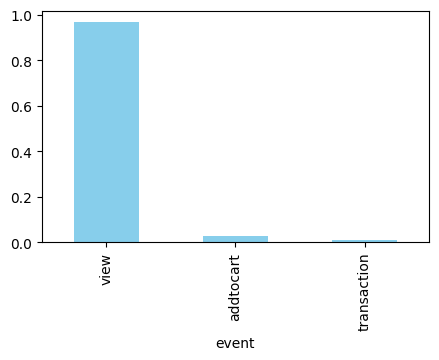

In [33]:
plt.figure(figsize=(5, 3))
events["event"].value_counts(normalize=True).plot(kind='bar', color='skyblue')

In [34]:
events['visitorid'].value_counts().head()

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
Name: count, dtype: int64

In [42]:
# Check id every transaction is associated with transaction id
assert events[events["transactionid"].notnull()].shape[0] == events[events["event"]=="transaction"].shape[0]
#Transaction id is not really relevant to the problem so we drop it
events.drop(['transactionid'],axis=1,inplace=True)

In [44]:
customer_item = pd.DataFrame(events.groupby(['visitorid','itemid','event'])['timestamp'].count().reset_index())
customer_item

visitorid  itemid event  timestamp
0                0   67045  view          1
1                0  285930  view          1
2                0  357564  view          1
3                1   72028  view          1
4                2  216305  view          2
...            ...     ...   ...        ...
2215417    1407575  121220  view          1
2215418    1407576  356208  view          1
2215419    1407577  427784  view          1
2215420    1407578  188736  view          1
2215421    1407579    2521  view          1

[2215422 rows x 4 columns]

In [46]:
top_items = pd.DataFrame(events['itemid'].value_counts())[:5000]
top_items

count
itemid       
187946   3412
461686   2978
5411     2334
370653   1854
219512   1800
...       ...
408907     90
223067     90
19648      90
18013      90
173653     90

[5000 rows x 1 columns]

In [47]:
customer_item_addtocart = customer_item[customer_item['event'] == 'addtocart']
print(customer_item_addtocart.shape[0])

62025


In [52]:
events=events.drop(['transactionid'],axis=1)

In [53]:
events

timestamp  visitorid event  itemid
0        1433221332117     257597  view  355908
1        1433224214164     992329  view  248676
2        1433221999827     111016  view  318965
3        1433221955914     483717  view  253185
4        1433221337106     951259  view  367447
...                ...        ...   ...     ...
2756096  1438398785939     591435  view  261427
2756097  1438399813142     762376  view  115946
2756098  1438397820527    1251746  view   78144
2756099  1438398530703    1184451  view  283392
2756100  1438400163914     199536  view  152913

[2756101 rows x 4 columns]

In [55]:
events[events['event']=="addtocart"].shape

(69332, 4)

In [88]:
from tensorflow.keras import models, layers

In [65]:
for user_id, user_events in user_groups:
    print(user_id,user_events)

1                      timestamp  visitorid event  itemid
830385 2015-08-13 17:46:06.444          1  view   72028
2                      timestamp  visitorid event  itemid
726292 2015-08-07 18:01:08.920          2  view  216305
728288 2015-08-07 18:20:57.845          2  view  325215
735202 2015-08-07 18:17:24.375          2  view  342816
735273 2015-08-07 17:53:33.790          2  view  325215
737615 2015-08-07 18:08:25.669          2  view  342816
737711 2015-08-07 17:56:52.664          2  view  259884
742485 2015-08-07 18:17:43.170          2  view  216305
742616 2015-08-07 17:51:44.567          2  view  325215
3                      timestamp  visitorid event  itemid
612379 2015-08-01 07:10:35.296          3  view  385090
5                       timestamp  visitorid event  itemid
2372299 2015-07-17 01:45:56.439          5  view   61396
6                       timestamp  visitorid      event  itemid
1130136 2015-08-30 06:40:23.805          6       view  344723
1130169 2015-08-30 06:54

KeyboardInterrupt: 

In [72]:
user_groups = events_train.groupby('visitorid')
        
for user_id, user_events in user_groups:
    print(user_id)
    user_events = user_events.sort_values('timestamp')
    history = user_events.iloc[:0].to_dict('records')
    target = user_events.iloc[0]
    # print(history)
    print(target)
    

    

1
timestamp    2015-08-13 17:46:06.444000
visitorid                             1
event                              view
itemid                            72028
Name: 830385, dtype: object
2
timestamp    2015-08-07 17:51:44.567000
visitorid                             2
event                              view
itemid                           325215
Name: 742616, dtype: object
3
timestamp    2015-08-01 07:10:35.296000
visitorid                             3
event                              view
itemid                           385090
Name: 612379, dtype: object
5
timestamp    2015-07-17 01:45:56.439000
visitorid                             5
event                              view
itemid                            61396
Name: 2372299, dtype: object
6
timestamp    2015-08-30 06:03:48.202000
visitorid                             6
event                         addtocart
itemid                            65273
Name: 1133190, dtype: object
7
timestamp    2015-05-14 05:39:36.753000
visito

KeyboardInterrupt: 

In [58]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Set
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm import tqdm
from datetime import datetime
import json
from transformers import BertTokenizer
import pickle
from pathlib import Path

class RecSysPreprocessor:
    def __init__(
        self,
        min_user_history: int = 5,
        max_user_history: int = 50,
        max_text_length: int = 64,
        validation_days: int = 7,
        negative_sample_size: int = 100
    ):
        self.min_user_history = min_user_history
        self.max_user_history = max_user_history
        self.max_text_length = max_text_length
        self.validation_days = validation_days
        self.negative_sample_size = negative_sample_size
        
        # Encoders
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.category_encoder = LabelEncoder()
        self.property_encoder = LabelEncoder()
        
        # Event type mapping
        self.event_type_map = {
            'view': 0,
            'add_to_cart': 1,
            'purchase': 2
        }
        
        # Initialize tokenizer for text properties
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def _encode_timestamps(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert timestamp strings to unix timestamps."""
        df['timestamp'] = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9
        return df
    
    def _compute_item_historical_features(
        self,
        events_df: pd.DataFrame
    ) -> Dict[int, np.ndarray]:
        """Compute historical item features like view-through rates."""
        features = defaultdict(lambda: defaultdict(int))
        
        # Count events per item
        for _, row in events_df.iterrows():
            features[row['item_id']][f'{row["event_type"]}_count'] += 1
            
        # Compute rates and create feature vectors
        item_features = {}
        for item_id, counts in features.items():
            total_views = counts.get('view_count', 0) + 1  # Add 1 for smoothing
            cart_rate = counts.get('add_to_cart_count', 0) / total_views
            purchase_rate = counts.get('purchase_count', 0) / total_views
            
            item_features[item_id] = np.array([
                np.log1p(total_views),
                cart_rate,
                purchase_rate,
                cart_rate / (purchase_rate + 1e-7),  # Cart-to-purchase ratio
                counts.get('purchase_count', 0) / (counts.get('add_to_cart_count', 0) + 1e-7)  # Purchase-to-cart ratio
            ])
        
        return item_features
    
    def _process_category_tree(
        self,
        category_tree: Dict[str, str]
    ) -> Tuple[Dict[int, List[int]], Set[int]]:
        """Process category tree to get item categories and root categories."""
        # Encode category IDs
        all_categories = set(list(category_tree.keys()) + list(category_tree.values()))
        self.category_encoder.fit(list(all_categories))
        
        # Create item to category path mapping
        item_categories = defaultdict(list)
        root_categories = set()
        
        for item_id, parent_id in category_tree.items():
            current_id = self.category_encoder.transform([item_id])[0]
            parent_encoded = self.category_encoder.transform([parent_id])[0]
            
            item_categories[current_id].append(current_id)
            item_categories[current_id].append(parent_encoded)
            
            if parent_id not in category_tree:
                root_categories.add(parent_encoded)
        
        return dict(item_categories), root_categories
    
    def _process_item_properties(
        self,
        properties_df: pd.DataFrame
    ) -> Tuple[Dict[int, List[int]], Dict[int, List[str]]]:
        """Process item properties, handling both categorical and text properties."""
        # Separate text and categorical properties
        text_properties = {}
        categorical_properties = defaultdict(list)
        
        # Fit property encoder on categorical values
        categorical_values = []
        for _, row in properties_df.iterrows():
            for prop, value in row.items():
                if isinstance(value, str) and len(value.split()) > 1:
                    continue
                categorical_values.append(str(value))
        
        self.property_encoder.fit(list(set(categorical_values)))
        
        # Process properties
        for _, row in properties_df.iterrows():
            item_id = row.name
            item_texts = []
            
            for prop, value in row.items():
                if isinstance(value, str) and len(value.split()) > 1:
                    # Text property
                    item_texts.append(value)
                else:
                    # Categorical property
                    encoded_value = self.property_encoder.transform([str(value)])[0]
                    categorical_properties[item_id].append(encoded_value)
            
            if item_texts:
                text_properties[item_id] = ' '.join(item_texts)
        
        return dict(categorical_properties), text_properties
    
    def _tokenize_text_properties(
        self,
        text_properties: Dict[int, str]
    ) -> Dict[int, np.ndarray]:
        """Tokenize text properties using BERT tokenizer."""
        tokenized_properties = {}
        
        for item_id, text in text_properties.items():
            tokens = self.tokenizer(
                text,
                max_length=self.max_text_length,
                padding='max_length',
                truncation=True,
                return_tensors='np'
            )
            tokenized_properties[item_id] = tokens['input_ids'][0]
        
        return tokenized_properties
    
    def _create_user_sequences(
        self,
        events_df: pd.DataFrame,
        split_timestamp: int
    ) -> Tuple[List[Dict], List[Dict]]:
        """Create user interaction sequences for training and validation."""
        train_sequences = []
        val_sequences = []
        
        # Group by user and sort by timestamp
        user_groups = events_df.groupby('user_id')
        
        for user_id, user_events in user_groups:
            user_events = user_events.sort_values('timestamp')
            
            # Split user events into train and validation
            train_events = user_events[user_events['timestamp'] < split_timestamp]
            val_events = user_events[user_events['timestamp'] >= split_timestamp]
            
            # Process training sequences
            if len(train_events) >= self.min_user_history:
                for i in range(self.min_user_history, len(train_events)):
                    history = train_events.iloc[:i].to_dict('records')
                    target = train_events.iloc[i]
                    
                    if target['event_type'] in ['add_to_cart', 'purchase']:
                        train_sequences.append({
                            'user_id': user_id,
                            'history': history[-self.max_user_history:],
                            'target_item': target['item_id'],
                            'label': 1
                        })
            
            # Process validation sequences
            if len(val_events) > 0 and len(train_events) >= self.min_user_history:
                history = train_events.to_dict('records')
                for _, target in val_events.iterrows():
                    if target['event_type'] in ['add_to_cart', 'purchase']:
                        val_sequences.append({
                            'user_id': user_id,
                            'history': history[-self.max_user_history:],
                            'target_item': target['item_id'],
                            'label': 1
                        })
        
        return train_sequences, val_sequences
    
    def _add_negative_samples(
        self,
        sequences: List[Dict],
        events_df: pd.DataFrame
    ) -> List[Dict]:
        """Add negative samples to sequences."""
        # Get all items and user-item interactions
        all_items = set(events_df['item_id'].unique())
        user_items = defaultdict(set)
        
        for _, row in events_df.iterrows():
            user_items[row['user_id']].add(row['item_id'])
        
        # Add negative samples
        augmented_sequences = []
        for seq in sequences:
            user_id = seq['user_id']
            positive_item = seq['target_item']
            
            # Get items user hasn't interacted with
            negative_candidates = list(all_items - user_items[user_id])
            
            # Sample negative items
            if len(negative_candidates) >= self.negative_sample_size:
                negative_items = np.random.choice(
                    negative_candidates,
                    size=self.negative_sample_size,
                    replace=False
                )
            else:
                negative_items = np.random.choice(
                    negative_candidates,
                    size=self.negative_sample_size,
                    replace=True
                )
            
            # Add positive sequence
            augmented_sequences.append(seq)
            
            # Add negative sequences
            for neg_item in negative_items:
                neg_seq = seq.copy()
                neg_seq['target_item'] = neg_item
                neg_seq['label'] = 0
                augmented_sequences.append(neg_seq)
        
        return augmented_sequences
    
    def preprocess(
        self,
        events_df: pd.DataFrame,
        properties_df: pd.DataFrame,
        category_tree: Dict[str, str],
        output_path: str = None
    ) -> Dict:
        """Main preprocessing function."""
        # Convert timestamps
        events_df = self._encode_timestamps(events_df)
        
        # Encode users and items
        self.user_encoder.fit(events_df['user_id'].unique())
        self.item_encoder.fit(events_df['item_id'].unique())
        
        events_df['user_id'] = self.user_encoder.transform(events_df['user_id'])
        events_df['item_id'] = self.item_encoder.transform(events_df['item_id'])
        events_df['event_type'] = events_df['event_type'].map(self.event_type_map)
        
        # Process category tree
        item_categories, root_categories = self._process_category_tree(category_tree)
        
        # Process item properties
        categorical_properties, text_properties = self._process_item_properties(properties_df)
        tokenized_properties = self._tokenize_text_properties(text_properties)
        
        # Compute historical features
        item_historical_features = self._compute_item_historical_features(events_df)
        
        # Split data
        split_timestamp = events_df['timestamp'].max() - (self.validation_days * 24 * 3600)
        train_sequences, val_sequences = self._create_user_sequences(
            events_df,
            split_timestamp
        )
        
        # Add negative samples
        train_sequences = self._add_negative_samples(train_sequences, events_df)
        val_sequences = self._add_negative_samples(val_sequences, events_df)
        
        # Prepare output
        processed_data = {
            'train_sequences': train_sequences,
            'val_sequences': val_sequences,
            'item_categories': item_categories,
            'categorical_properties': categorical_properties,
            'tokenized_properties': tokenized_properties,
            'item_historical_features': item_historical_features,
            'encoders': {
                'user_encoder': self.user_encoder,
                'item_encoder': self.item_encoder,
                'category_encoder': self.category_encoder,
                'property_encoder': self.property_encoder
            },
            'metadata': {
                'root_categories': root_categories,
                'event_type_map': self.event_type_map,
                'n_users': len(self.user_encoder.classes_),
                'n_items': len(self.item_encoder.classes_),
                'n_categories': len(self.category_encoder.classes_),
                'n_properties': len(self.property_encoder.classes_)
            }
        }
        
        # Save if output path provided
        if output_path:
            with open(output_path, 'wb') as f:
                pickle.dump(processed_data, f)
        
        return processed_data

# Example usage:
def preprocess_data(
    events_path: str,
    properties_path: str,
    category_tree_path: str,
    output_path: str
) -> Dict:
    """Helper function to load and preprocess data."""
    # Load data
    events_df = pd.read_csv(events_path)
    properties_df = pd.read_csv(properties_path, index_col='item_id')
    
    with open(category_tree_path, 'r') as f:
        category_tree = json.load(f)
    
    # Initialize preprocessor
    preprocessor = RecSysPreprocessor(
        min_user_history=5,
        max_user_history=50,
        max_text_length=64,
        validation_days=7,
        negative_sample_size=100
    )
    
    # Process data
    processed_data = preprocessor.preprocess(
        events_df,
        properties_df,
        category_tree,
        output_path
    )
    
    return processed_data

visitorid
1150086    1278
152963      720
530559      705
76757       481
684514      420
           ... 
1117785       1
461854        1
501677        1
426475        1
144106        1
Name: count, Length: 38865, dtype: int64

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Dict, Tuple

class ItemTower(nn.Module):
    def __init__(
        self,
        num_properties: int,
        property_embedding_dim: int,
        category_embedding_dim: int,
        historical_features_dim: int,
        final_embedding_dim: int,
        mlp_hidden_dims: List[int] = [512, 256]
    ):
        super().__init__()
        
        # Property embeddings
        self.property_embeddings = nn.Embedding(num_properties, property_embedding_dim)
        
        # Category embeddings
        self.category_embeddings = nn.Embedding(num_properties, category_embedding_dim)
        
        # Combined input dimension
        combined_dim = (property_embedding_dim + category_embedding_dim + 
                       historical_features_dim)
        
        # MLP layers
        layers = []
        prev_dim = combined_dim
        for hidden_dim in mlp_hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
            
        # Final projection layer
        layers.append(nn.Linear(prev_dim, final_embedding_dim))
        
        self.mlp = nn.Sequential(*layers)
        
    def forward(
        self,
        property_indices: torch.Tensor,  # Shape: [batch_size, num_properties]
        category_indices: torch.Tensor,  # Shape: [batch_size, num_categories]
        historical_features: torch.Tensor  # Shape: [batch_size, historical_features_dim]
    ) -> torch.Tensor:
        # Get embeddings
        property_embeds = self.property_embeddings(property_indices).mean(dim=1)  # Average across properties
        category_embeds = self.category_embeddings(category_indices).mean(dim=1)  # Average across categories
        
        # Concatenate all features
        combined = torch.cat([property_embeds, category_embeds, historical_features], dim=1)
        
        # Pass through MLP
        item_embedding = self.mlp(combined)
        
        # Normalize to unit length
        return F.normalize(item_embedding, p=2, dim=1)

class UserTower(nn.Module):
    def __init__(
        self,
        item_embedding_dim: int,
        event_embedding_dim: int,
        hidden_dim: int,
        final_embedding_dim: int
    ):
        super().__init__()
        
        # Event type embedding
        self.event_embeddings = nn.Embedding(3, event_embedding_dim)  # 3 event types
        
        # GRU for sequential processing
        self.gru = nn.GRU(
            input_size=item_embedding_dim + event_embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Final projection
        self.projection = nn.Linear(hidden_dim, final_embedding_dim)
        
    def forward(
        self,
        item_embeddings: torch.Tensor,  # Shape: [batch_size, seq_len, item_embedding_dim]
        event_types: torch.Tensor,      # Shape: [batch_size, seq_len]
        lengths: torch.Tensor           # Shape: [batch_size]
    ) -> torch.Tensor:
        # Get event embeddings
        event_embeds = self.event_embeddings(event_types)
        
        # Concatenate item and event embeddings
        combined = torch.cat([item_embeddings, event_embeds], dim=-1)
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            combined, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # Process through GRU
        _, hidden = self.gru(packed)
        
        # Project to final dimension
        user_embedding = self.projection(hidden.squeeze(0))
        
        # Normalize to unit length
        return F.normalize(user_embedding, p=2, dim=1)

class TwoTowerModel(nn.Module):
    def __init__(
        self,
        item_tower: ItemTower,
        user_tower: UserTower,
        temperature: float = 0.07
    ):
        super().__init__()
        self.item_tower = item_tower
        self.user_tower = user_tower
        self.temperature = temperature
        
    def forward(
        self,
        user_history_items: torch.Tensor,
        user_history_events: torch.Tensor,
        user_history_lengths: torch.Tensor,
        candidate_items_properties: torch.Tensor,
        candidate_items_categories: torch.Tensor,
        candidate_items_historical: torch.Tensor
    ) -> torch.Tensor:
        # Get item embeddings for user history
        history_item_embeds = self.item_tower(
            user_history_items,
            user_history_events,
            candidate_items_historical
        )
        
        # Get user embedding
        user_embed = self.user_tower(
            history_item_embeds,
            user_history_events,
            user_history_lengths
        )
        
        # Get candidate item embeddings
        candidate_embeds = self.item_tower(
            candidate_items_properties,
            candidate_items_categories,
            candidate_items_historical
        )
        
        # Compute scaled dot product
        logits = torch.matmul(user_embed, candidate_embeds.t()) / self.temperature
        
        return logits

class RecommenderDataset(Dataset):
    def __init__(
        self,
        user_events: List[Dict],
        item_properties: Dict[int, List[int]],
        item_categories: Dict[int, List[int]],
        item_historical_features: Dict[int, np.ndarray],
        max_seq_length: int = 50
    ):
        self.user_events = user_events
        self.item_properties = item_properties
        self.item_categories = item_categories
        self.item_historical_features = item_historical_features
        self.max_seq_length = max_seq_length
        
    def __len__(self) -> int:
        return len(self.user_events)
        
    def __getitem__(self, idx: int) -> Tuple:
        user_data = self.user_events[idx]
        
        # Get user history
        history = user_data['history'][-self.max_seq_length:]
        history_items = [h['item_id'] for h in history]
        history_events = [h['event_type'] for h in history]
        
        # Get target item
        target_item = user_data['target_item']
        
        # Convert to tensors
        history_items = torch.tensor(history_items)
        history_events = torch.tensor(history_events)
        history_length = torch.tensor(len(history))
        
        # Get item features
        item_props = torch.tensor(self.item_properties[target_item])
        item_cats = torch.tensor(self.item_categories[target_item])
        item_hist = torch.tensor(self.item_historical_features[target_item])
        
        return (
            history_items, history_events, history_length,
            item_props, item_cats, item_hist,
            torch.tensor(user_data['label'])
        )

def train_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    batch: Tuple,
    device: torch.device
) -> float:
    model.train()
    optimizer.zero_grad()
    
    # Unpack batch
    (history_items, history_events, history_length,
     item_props, item_cats, item_hist, labels) = [x.to(device) for x in batch]
    
    # Forward pass
    logits = model(
        history_items, history_events, history_length,
        item_props, item_cats, item_hist
    )
    
    # Calculate loss
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [ ]:
item_tower = ItemTower(
    num_properties=1000,
    property_embedding_dim=64,
    category_embedding_dim=32,
    historical_features_dim=50,
    final_embedding_dim=128
)

user_tower = UserTower(
    item_embedding_dim=128,
    event_embedding_dim=16,
    hidden_dim=256,
    final_embedding_dim=128
)

model = TwoTowerModel(item_tower, user_tower, temperature=0.07)

In [ ]:
dataset = RecommenderDataset(
    user_events=user_events,
    item_properties=item_properties,
    item_categories=item_categories,
    item_historical_features=item_historical_features
)

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

In [59]:
item_properties

timestamp  itemid    property                             value
0         1435460400000  460429  categoryid                              1338
1         1441508400000  206783         888           1116713 960601 n277.200
2         1439089200000  395014         400   n552.000 639502 n720.000 424566
3         1431226800000   59481         790                        n15360.000
4         1431831600000  156781         917                            828513
...                 ...     ...         ...                               ...
20275897  1433646000000  236931         929                           n12.000
20275898  1440903600000  455746           6                     150169 639134
20275899  1439694000000  347565         686                            610834
20275900  1433646000000  287231         867                            769062
20275901  1442113200000  275768         888  888666 n10800.000 746840 1318567

[20275902 rows x 4 columns]

In [62]:
transformed_df =item_properties.pivot(index=['timestamp','itemid'], columns='property', values='value')
    
# Reset the index to make itemid a column
transformed_df = transformed_df.reset_index()

KeyboardInterrupt: 